In [1]:
from datasets import load_dataset

# Load the dataset to inspect available splits
dataset = load_dataset('Amod/mental_health_counseling_conversations')

# Print available splits
print(dataset)


Generating train split:   0%|          | 0/3512 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Context', 'Response'],
        num_rows: 3512
    })
})


In [3]:
train_dataset = dataset['train']
train_df = train_dataset.to_pandas()
train_df.to_csv('train_data.csv', index=False)
print("Train data saved to train_data.csv")

Train data saved to train_data.csv


In [4]:
# Function to create the formatted prompt
def create_prompt(row):
    return f"###Question : {row['Context']} ###Answer : {row['Response']}"

In [5]:
train_df['text'] = train_df.apply(create_prompt, axis=1)

In [6]:
train_df = train_df.drop(['Context', 'Response'], axis=1)


In [7]:
training_dataset = train_df.head(2809)
testing_dataset = train_df[2809:]


In [8]:
training_dataset.to_csv('training_dataset.csv', index=False)
testing_dataset.to_csv('testing_dataset.csv', index=False)
print("Train and test data saved")

Train and test data saved


In [9]:
from datasets import Dataset

hf_train  = Dataset.from_pandas(training_dataset)
hf_test = Dataset.from_pandas(testing_dataset)

In [11]:
print(hf_train,hf_test)

Dataset({
    features: ['text'],
    num_rows: 2809
}) Dataset({
    features: ['text'],
    num_rows: 703
})


In [12]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [41]:
import wandb, os
wandb.login()

wandb_project = "medical-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [21]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, BitsAndBytesConfig ,AutoTokenizer

base_model_id = "google/flan-t5-base"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = T5ForConditionalGeneration.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [22]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(create_prompt(prompt))

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

3512


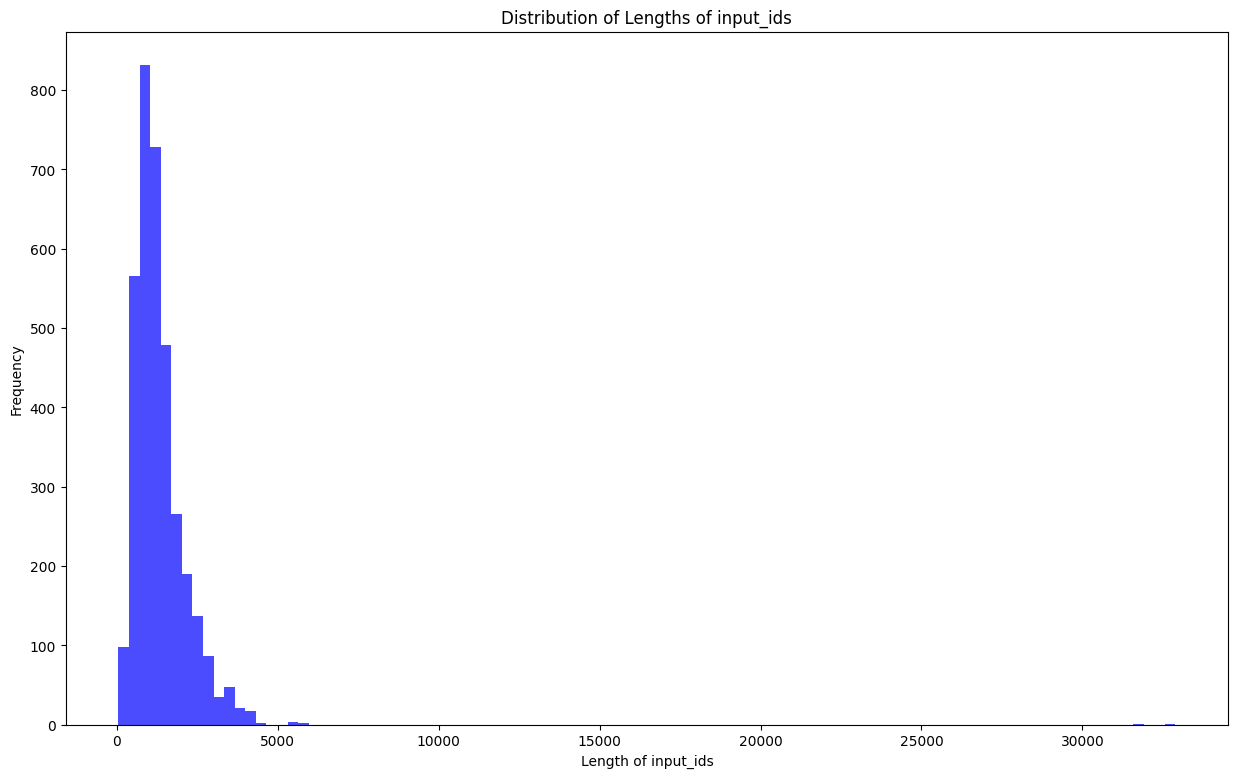

In [28]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['text']) for x in tokenized_train_dataset]
    lengths += [len(x['text']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(15, 9))
    plt.hist(lengths, bins=100, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(hf_train, hf_test)

In [30]:
max_length = 1000 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(example):
    result = tokenizer(
        example['text'],
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [31]:
tokenized_train_dataset = hf_train.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = hf_test.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/2809 [00:00<?, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

In [32]:
print(tokenized_train_dataset)

Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2809
})


In [33]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [34]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [35]:
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear4bit(in_features=768, out_features=768, bias=False)
              (k): Linear4bit(in_features=768, out_features=768, bias=False)
              (v): Linear4bit(in_features=768, out_features=768, bias=False)
              (o): Linear4bit(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear4bit(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear4bit(in_features=768, out_features=2048, bias=Fa

In [36]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q",
        "k",
        "v",
        "o",
        "wi_0",
        "wi_1",
        "wo",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 13565952 || all params: 180927744 || trainable%: 7.497994337452193


In [37]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=768, out_features=768, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=32, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=32, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
     

In [38]:
model = accelerator.prepare_model(model)

In [42]:
import transformers
from datetime import datetime

project = "medical-finetune"
base_model_name = "flan-t5-base"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=100,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

d:\newenv\lib\site-packages\transformers\training_args.py:1483: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.5041, 'grad_norm': 0.800885796546936, 'learning_rate': 1.9076305220883535e-05, 'epoch': 0.02}
{'loss': 0.3829, 'grad_norm': 0.6755754947662354, 'learning_rate': 1.807228915662651e-05, 'epoch': 0.04}


d:\newenv\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.2599, 'grad_norm': 0.7544741034507751, 'learning_rate': 1.7068273092369478e-05, 'epoch': 0.05}
{'loss': 0.2193, 'grad_norm': 0.5226228833198547, 'learning_rate': 1.606425702811245e-05, 'epoch': 0.07}


  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.057217638939619064, 'eval_runtime': 2497.923, 'eval_samples_per_second': 0.281, 'eval_steps_per_second': 0.035, 'epoch': 0.07}


d:\newenv\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.1524, 'grad_norm': 0.5141634345054626, 'learning_rate': 1.5060240963855424e-05, 'epoch': 0.09}
{'loss': 0.1414, 'grad_norm': 0.5617107152938843, 'learning_rate': 1.4056224899598394e-05, 'epoch': 0.11}


d:\newenv\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.1222, 'grad_norm': 0.5457544922828674, 'learning_rate': 1.3052208835341367e-05, 'epoch': 0.12}
{'loss': 0.1049, 'grad_norm': 0.4674505293369293, 'learning_rate': 1.204819277108434e-05, 'epoch': 0.14}


  0%|          | 0/88 [00:00<?, ?it/s]

{'eval_loss': 0.026491636410355568, 'eval_runtime': 2512.0076, 'eval_samples_per_second': 0.28, 'eval_steps_per_second': 0.035, 'epoch': 0.14}


d:\newenv\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.098, 'grad_norm': 0.8399213552474976, 'learning_rate': 1.104417670682731e-05, 'epoch': 0.16}
{'loss': 0.0826, 'grad_norm': 0.3447604477405548, 'learning_rate': 1.0040160642570283e-05, 'epoch': 0.18}


d:\newenv\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0873, 'grad_norm': 0.6760973930358887, 'learning_rate': 9.036144578313254e-06, 'epoch': 0.2}
{'loss': 0.0756, 'grad_norm': 0.3533364534378052, 'learning_rate': 8.032128514056226e-06, 'epoch': 0.21}


  0%|          | 0/88 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
from huggingface_hub import login
import os
from dotenv import load_dotenv

hf_api_key = os.getenv('HUGGINGFACE_API_KEY')

login(token=hf_api_key)

In [45]:
model.push_to_hub('siddharth-magesh/flan-t5-base-medical-finetune')
tokenizer.push_to_hub('siddharth-magesh/flan-t5-base-medical-finetune')

adapter_model.safetensors:   0%|          | 0.00/54.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

d:\newenv\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Siddharth\.cache\huggingface\hub\models--siddharth-magesh--flan-t5-base-medical-finetune. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/siddharth-magesh/flan-t5-base-medical-finetune/commit/8476d4377fc2682fb78916d54420b165eec17711', commit_message='Upload tokenizer', commit_description='', oid='8476d4377fc2682fb78916d54420b165eec17711', pr_url=None, pr_revision=None, pr_num=None)